# <center> SER (CREMA-D) </center>

In [1]:
!nvidia-smi

Fri Jan  2 09:34:49 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/VuTrinhNguyenHoang/Speech-Emotion-Learning.git speech.ser
%cd speech.ser
!ls

Cloning into 'speech.ser'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 71 (delta 32), reused 55 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 15.33 KiB | 5.11 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/kaggle/working/speech.ser
README.md  requirements.txt  scripts  src


In [3]:
!pip -q install -r requirements.txt

In [4]:
# copy the dataset from kaggle input 
!mkdir -p data/raw/CREMA-D
!cp -r /kaggle/input/cremad/AudioWAV data/raw/CREMA-D/AudioWAV

In [5]:
!python -m scripts.prepare_splits
!ls data/splits

[OK] train: 5147 -> /kaggle/working/speech.ser/data/splits/crema_train.csv
[OK] val: 1066 -> /kaggle/working/speech.ser/data/splits/crema_val.csv
[OK] test: 1229 -> /kaggle/working/speech.ser/data/splits/crema_test.csv
train unique speakers: 63
val unique speakers: 13
test unique speakers: 15
crema_test.csv	crema_train.csv  crema_val.csv


In [6]:
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

!python -m scripts.cache_logmel

Cache crema_train.csv: 100%|███████████████| 5147/5147 [00:46<00:00, 109.83it/s]
[OK] wrote=5147, skipped(existing)=0, out_dir=/kaggle/working/speech.ser/data/processed/logmel_3s_16k_nmel80/train
Cache crema_val.csv: 100%|█████████████████| 1066/1066 [00:09<00:00, 110.75it/s]
[OK] wrote=1066, skipped(existing)=0, out_dir=/kaggle/working/speech.ser/data/processed/logmel_3s_16k_nmel80/val
Cache crema_test.csv: 100%|████████████████| 1229/1229 [00:11<00:00, 107.72it/s]
[OK] wrote=1229, skipped(existing)=0, out_dir=/kaggle/working/speech.ser/data/processed/logmel_3s_16k_nmel80/test


# <center> Quick EDA </center>

In [7]:
import pandas as pd
from src.paths import SPLITS_DIR, CREMA_WAV_DIR
from src.data.crema import scan_crema

# Scan all CREMA-D items
items = scan_crema(CREMA_WAV_DIR)
df = pd.DataFrame([{'path': str(it.path), 'speaker': it.speaker, 'emotion': it.emotion} for it in items])

print(f'Total samples: {len(df)}')
print(f'Unique speakers: {df["speaker"].nunique()}')
print(f'Unique emotions: {df["emotion"].nunique()}')

df.head(10)

Total samples: 7442
Unique speakers: 91
Unique emotions: 6


,path,speaker,emotion
0,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,angry
1,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,disgust
2,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,fear
3,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,happy
4,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,neutral
5,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,sad
6,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,angry
7,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,angry
8,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,angry
9,/kaggle/working/speech.ser/data/raw/CREMA-D/Au...,1001,disgust


### Emotion & Speaker Distribution

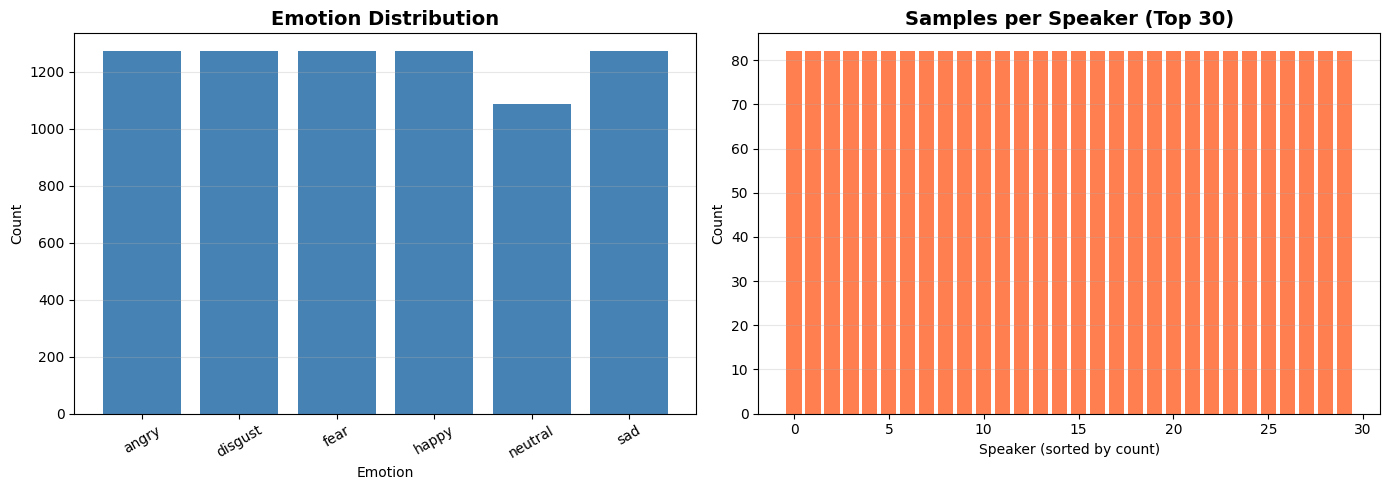


Emotion stats:
emotion
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: count, dtype: int64

Speaker stats: min=76, max=82, mean=81.8


In [8]:
import matplotlib.pyplot as plt

# Emotion distribution
emo_counts = df['emotion'].value_counts().sort_index()
spk_counts = df['speaker'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot emotion distribution
axes[0].bar(emo_counts.index, emo_counts.values, color='steelblue')
axes[0].set_title('Emotion Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)
axes[0].grid(axis='y', alpha=0.3)

# Plot speaker distribution (top 30)
top_speakers = spk_counts.head(30)
axes[1].bar(range(len(top_speakers)), top_speakers.values, color='coral')
axes[1].set_title('Samples per Speaker (Top 30)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Speaker (sorted by count)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nEmotion stats:\n{emo_counts}')
print(f'\nSpeaker stats: min={spk_counts.min()}, max={spk_counts.max()}, mean={spk_counts.mean():.1f}')

### Sample Waveform & Log-Mel Visualization

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

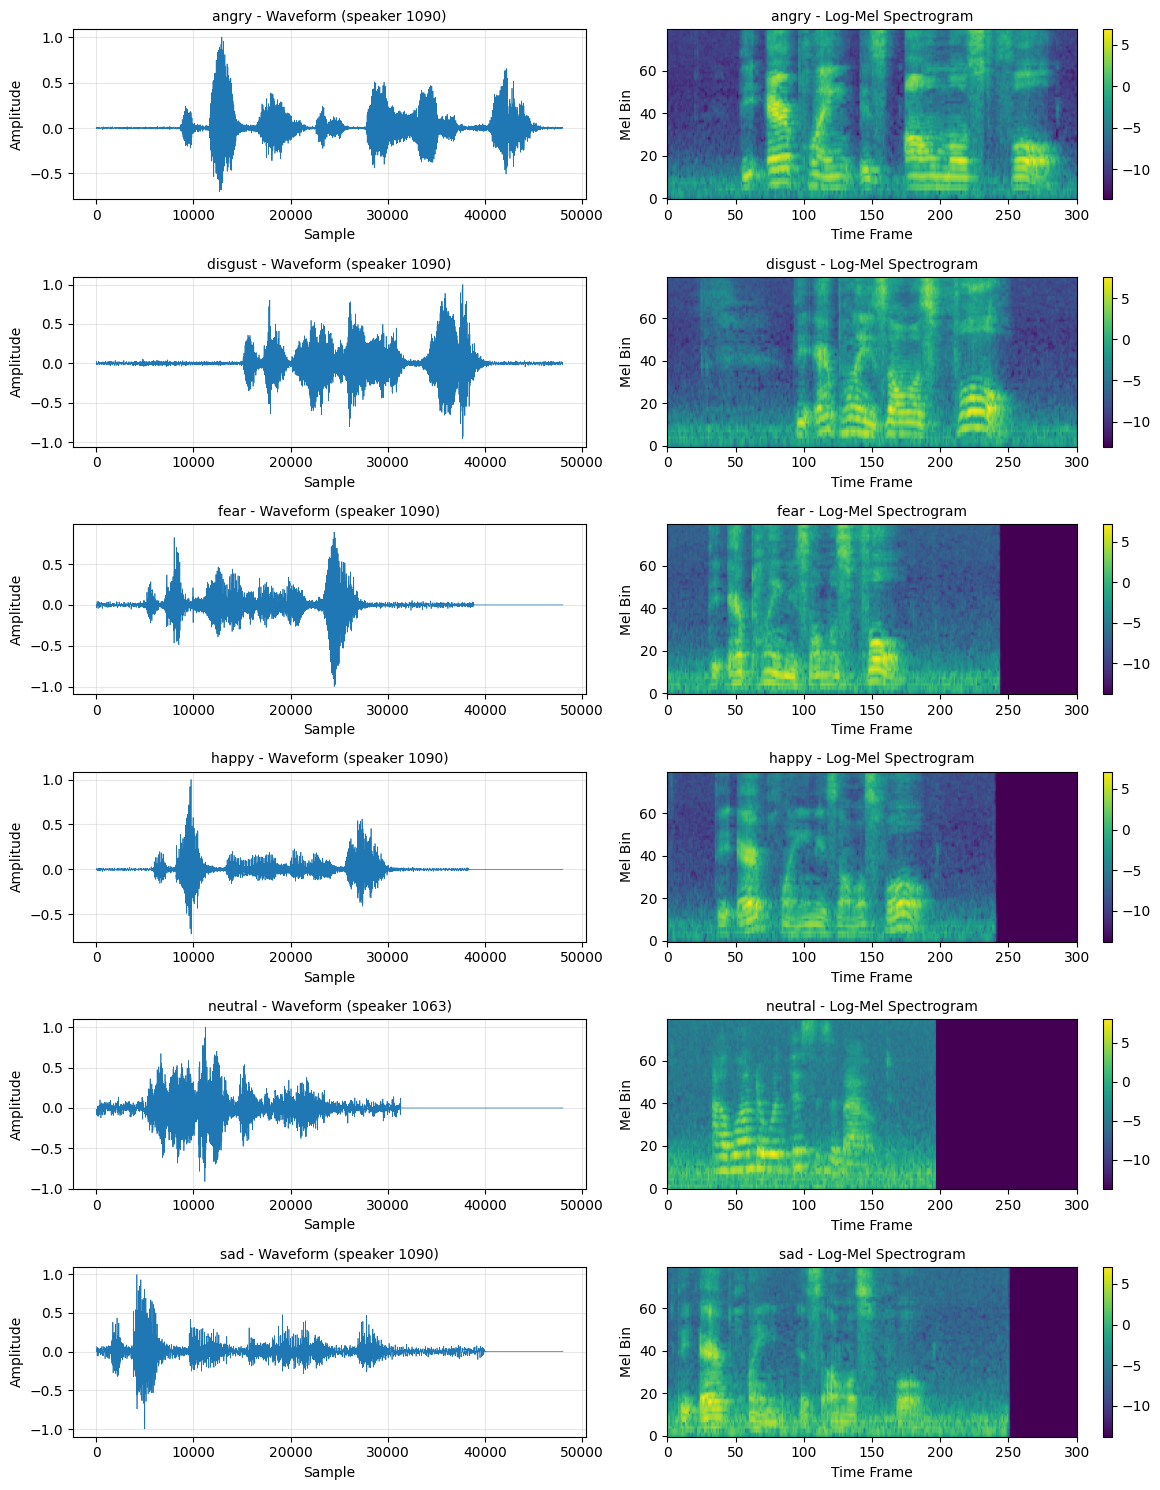

In [9]:
import random
from src.config import SAMPLE_RATE, DURATION_SEC
from src.data.audio import load_mono_resample, pad_or_crop, peak_normalize
from src.data.features import log_mel

# Pick random samples from each emotion
emotions = df['emotion'].unique()
n_emotions = len(emotions)

fig, axes = plt.subplots(n_emotions, 2, figsize=(12, 2.5 * n_emotions))
if n_emotions == 1:
    axes = axes.reshape(1, -1)

for i, emo in enumerate(sorted(emotions)):
    # Get random sample of this emotion
    sample = df[df['emotion'] == emo].sample(1, random_state=42).iloc[0]
    wav_path = sample['path']
    
    # Load and preprocess
    wav, _ = load_mono_resample(wav_path, SAMPLE_RATE)
    wav = peak_normalize(wav)
    wav = pad_or_crop(wav, int(SAMPLE_RATE * DURATION_SEC))
    
    # Compute log-mel
    lm = log_mel(wav)  # [80, T]
    
    # Plot waveform
    axes[i, 0].plot(wav.squeeze(0).numpy(), linewidth=0.5)
    axes[i, 0].set_title(f'{emo} - Waveform (speaker {sample["speaker"]})', fontsize=10)
    axes[i, 0].set_xlabel('Sample')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(alpha=0.3)
    
    # Plot log-mel spectrogram
    im = axes[i, 1].imshow(lm.numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[i, 1].set_title(f'{emo} - Log-Mel Spectrogram', fontsize=10)
    axes[i, 1].set_xlabel('Time Frame')
    axes[i, 1].set_ylabel('Mel Bin')
    plt.colorbar(im, ax=axes[i, 1])

plt.tight_layout()
plt.show()

### Check Generated Splits

In [10]:
# Load and analyze splits
splits = {}
for split_name in ['train', 'val', 'test']:
    csv_path = SPLITS_DIR / f'crema_{split_name}.csv'
    if csv_path.exists():
        splits[split_name] = pd.read_csv(csv_path)
        print(f'\n{split_name.upper()} Split:')
        print(f'  Samples: {len(splits[split_name])}')
        print(f'  Speakers: {splits[split_name]["speaker"].nunique()}')
        print(f'  Emotions: {splits[split_name]["emotion"].value_counts().to_dict()}')

# Verify speaker independence
if len(splits) == 3:
    train_spks = set(splits['train']['speaker'].unique())
    val_spks = set(splits['val']['speaker'].unique())
    test_spks = set(splits['test']['speaker'].unique())
    
    print(f'\n\nSpeaker Independence Check:')
    print(f'  Train ∩ Val: {len(train_spks & val_spks)} speakers (should be 0)')
    print(f'  Train ∩ Test: {len(train_spks & test_spks)} speakers (should be 0)')
    print(f'  Val ∩ Test: {len(val_spks & test_spks)} speakers (should be 0)')
    
    if len(train_spks & val_spks) == 0 and len(train_spks & test_spks) == 0 and len(val_spks & test_spks) == 0:
        print('  Speaker-independent splits verified!')


TRAIN Split:
  Samples: 5147
  Speakers: 63
  Emotions: {'angry': 879, 'disgust': 879, 'fear': 879, 'happy': 879, 'sad': 879, 'neutral': 752}

VAL Split:
  Samples: 1066
  Speakers: 13
  Emotions: {'angry': 182, 'disgust': 182, 'fear': 182, 'happy': 182, 'sad': 182, 'neutral': 156}

TEST Split:
  Samples: 1229
  Speakers: 15
  Emotions: {'angry': 210, 'disgust': 210, 'fear': 210, 'happy': 210, 'sad': 210, 'neutral': 179}


Speaker Independence Check:
  Train ∩ Val: 0 speakers (should be 0)
  Train ∩ Test: 0 speakers (should be 0)
  Val ∩ Test: 0 speakers (should be 0)
  Speaker-independent splits verified!


### Check Cached Log-Mel Features

In [11]:
import torch
from src.paths import PROCESSED_DIR

cache_root = PROCESSED_DIR / 'logmel_3s_16k_nmel80'

for split_name in ['train', 'val', 'test']:
    split_dir = cache_root / split_name
    if split_dir.exists():
        cached_files = list(split_dir.glob('*.pt'))
        print(f'\n{split_name.upper()}: {len(cached_files)} cached .pt files')
        
        # Load and inspect first sample
        if cached_files:
            sample = torch.load(cached_files[0])
            print(f'  Sample keys: {list(sample.keys())}')
            print(f'  x shape: {sample["x"].shape}')
            print(f'  y (label): {sample["y"]}')
            print(f'  speaker: {sample["speaker"]}')


TRAIN: 5147 cached .pt files
  Sample keys: ['x', 'y', 'speaker', 'path']
  x shape: torch.Size([80, 301])
  y (label): 3
  speaker: 1084

VAL: 1066 cached .pt files
  Sample keys: ['x', 'y', 'speaker', 'path']
  x shape: torch.Size([80, 301])
  y (label): 5
  speaker: 1088

TEST: 1229 cached .pt files
  Sample keys: ['x', 'y', 'speaker', 'path']
  x shape: torch.Size([80, 301])
  y (label): 2
  speaker: 1070


# <center> SER with Machine Learning </center>

In [12]:
!python -m src.train_ml

Loading crema_test.csv: 100%|█████████████| 1229/1229 [00:01<00:00, 1092.90it/s]

[VAL]
               precision    recall  f1-score   support

       angry     0.5734    0.6868    0.6250       182
     disgust     0.4113    0.3187    0.3591       182
        fear     0.3016    0.2088    0.2468       182
       happy     0.3727    0.3297    0.3499       182
     neutral     0.3826    0.3654    0.3738       156
         sad     0.4022    0.5989    0.4812       182

    accuracy                         0.4193      1066
   macro avg     0.4073    0.4180    0.4060      1066
weighted avg     0.4079    0.4193    0.4067      1066


[TEST]
               precision    recall  f1-score   support

       angry     0.4286    0.7286    0.5397       210
     disgust     0.3483    0.3333    0.3406       210
        fear     0.3946    0.2762    0.3249       210
       happy     0.3788    0.3571    0.3676       210
     neutral     0.4023    0.1955    0.2632       179
         sad     0.4812    0.5476 

# <center> SER with Deep Learning </center>

In [13]:
!python -m src.train_dl --arch SimpleCNN --batch_size 64 --epochs 30 --lr 0.001 --num_workers 4 --seed 42 --patience 5

Epoch 01 | train_loss=1.5252 | val_loss=1.4892 | val_macroF1=0.3371
  [OK] saved best -> best_simplecnn.pt (val_macroF1=0.3371)
Epoch 02 | train_loss=1.4384 | val_loss=1.4751 | val_macroF1=0.3358
Epoch 03 | train_loss=1.4134 | val_loss=1.6330 | val_macroF1=0.2512
Epoch 04 | train_loss=1.3966 | val_loss=1.3907 | val_macroF1=0.3846
  [OK] saved best -> best_simplecnn.pt (val_macroF1=0.3846)
Epoch 05 | train_loss=1.3717 | val_loss=1.3817 | val_macroF1=0.4393
  [OK] saved best -> best_simplecnn.pt (val_macroF1=0.4393)
Epoch 06 | train_loss=1.3619 | val_loss=1.3828 | val_macroF1=0.3929
Epoch 07 | train_loss=1.3458 | val_loss=1.4689 | val_macroF1=0.3377
Epoch 08 | train_loss=1.3464 | val_loss=1.3539 | val_macroF1=0.4076
Epoch 09 | train_loss=1.3322 | val_loss=1.5012 | val_macroF1=0.3195
Epoch 10 | train_loss=1.3248 | val_loss=1.4174 | val_macroF1=0.3843
  [STOP] early stopping

[TEST] loss=1.4547 macroF1=0.4253

              precision    recall  f1-score   support

       angry     0.5743  

In [14]:
!python -m src.train_dl --arch ResNet18 --batch_size 64 --epochs 30 --lr 0.001 --num_workers 4 --seed 42 --patience 5

Epoch 01 | train_loss=1.4048 | val_loss=2.4906 | val_macroF1=0.3046
  [OK] saved best -> best_resnet18.pt (val_macroF1=0.3046)
Epoch 02 | train_loss=1.1965 | val_loss=1.2126 | val_macroF1=0.4943
  [OK] saved best -> best_resnet18.pt (val_macroF1=0.4943)
Epoch 03 | train_loss=1.0804 | val_loss=1.2140 | val_macroF1=0.5265
  [OK] saved best -> best_resnet18.pt (val_macroF1=0.5265)
Epoch 04 | train_loss=0.9950 | val_loss=1.1938 | val_macroF1=0.5217
Epoch 05 | train_loss=0.9405 | val_loss=1.1594 | val_macroF1=0.5453
  [OK] saved best -> best_resnet18.pt (val_macroF1=0.5453)
Epoch 06 | train_loss=0.8530 | val_loss=1.3448 | val_macroF1=0.5213
Epoch 07 | train_loss=0.7632 | val_loss=1.9453 | val_macroF1=0.4210
Epoch 08 | train_loss=0.7026 | val_loss=1.6216 | val_macroF1=0.4972
Epoch 09 | train_loss=0.5921 | val_loss=1.3423 | val_macroF1=0.5728
  [OK] saved best -> best_resnet18.pt (val_macroF1=0.5728)
Epoch 10 | train_loss=0.4891 | val_loss=2.0602 | val_macroF1=0.4577
Epoch 11 | train_loss=0.4

In [15]:
!python -m src.train_dl --arch Transformer --batch_size 64 --epochs 30 --lr 0.0003 --num_workers 4 --seed 42 --patience 5

Epoch 01 | train_loss=1.5345 | val_loss=1.4492 | val_macroF1=0.4037
  [OK] saved best -> best_transformer.pt (val_macroF1=0.4037)
Epoch 02 | train_loss=1.3486 | val_loss=1.3702 | val_macroF1=0.4578
  [OK] saved best -> best_transformer.pt (val_macroF1=0.4578)
Epoch 03 | train_loss=1.2525 | val_loss=1.2589 | val_macroF1=0.4939
  [OK] saved best -> best_transformer.pt (val_macroF1=0.4939)
Epoch 04 | train_loss=1.1578 | val_loss=1.2687 | val_macroF1=0.4857
Epoch 05 | train_loss=1.0948 | val_loss=1.2222 | val_macroF1=0.5256
  [OK] saved best -> best_transformer.pt (val_macroF1=0.5256)
Epoch 06 | train_loss=1.0417 | val_loss=1.4282 | val_macroF1=0.4597
Epoch 07 | train_loss=0.9983 | val_loss=1.1652 | val_macroF1=0.5559
  [OK] saved best -> best_transformer.pt (val_macroF1=0.5559)
Epoch 08 | train_loss=0.9120 | val_loss=1.1916 | val_macroF1=0.5369
Epoch 09 | train_loss=0.8396 | val_loss=1.3504 | val_macroF1=0.5373
Epoch 10 | train_loss=0.7703 | val_loss=1.2866 | val_macroF1=0.5482
Epoch 11 |

---